In [1]:
%load_ext autoreload
%autoreload 2

This notebook contains the training of ChromFormer on Fission Yeast synthetic ClusterWalk data. This notebook contains as well structure prediction, confidence prediction and calibration models.

In [2]:
import torch
import random
import numpy as np
import os 
from torch_geometric.data import DataLoader

from ChromFormer.Data_Tools.Data_Access import get_data_from_path, VanillaDataset, set_logits_data
from ChromFormer.Data_Tools.Data_Plotting import plot_structure_in_sphere, plot_hic, plot_optimal_transport, plot_losses, plot_test_distance_matrix, plot_true_pred_structures, plot_hist_kabsch_distances, plot_grad_flow, plot_pred_conf
from ChromFormer.Model.model import UniformLinear, train_uniform_linear, evaluate_uniform_linear, ConfLinear, train_conf_linear, evaluate_conf_linear, TransConf, train_trans_conf, evaluate_trans_conf
from ChromFormer.Model.losses import compute_trussart_test_kabsch_loss, biological_loss_fct, kabsch_loss_fct
from ChromFormer.Data_Tools.Data_Calculation import save_structure, import_trussart_data, kabsch_superimposition_numpy, kabsch_distance_numpy, make_gif, scale_logits, mse_unscaled_scaled, import_fission_yeast, FISH_values_Tanizawa, dist_Tanizawa_FISH, save_structure_fission_yeast
from ChromFormer.Model.lddt_tools import lddt, get_confidence_metrics
from ChromFormer.Model.calibration_nn import ModelWithTemperature, isotonic_calibration, beta_calibration
from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

NB_HEAD = 2
NB_HIDDEN = 100
NB_LAYERS = 1
DROPOUT = 0.1
SECD_HID = 48
ZERO_INIT = False
EXPONENT = 1
NUM_BINS_LOGITS = 100
NB_EPOCHS = 42
##47
SEED = 2
BATCH_SIZE = 10
NB_BINS = 1258
EMBEDDING_SIZE = 3
ANGLE_PRED = 3
LAMBDA_BIO = 0.1
LAMBDA_KABSCH = 0.1
LAMBDA_LDDT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
#The following uses the package python-dotenv that can be installed by pip to load the variable that contains your path to the data folder in a .env file 
DATA_DIR = os.environ.get('DATA_DIR')
DATA_PATH=f'{DATA_DIR}/biological_fission_yeast_uniform'
TRAIN_DATASET_SIZE = 400
TEST_DATASET_SIZE = 100
FISH_Tanizawa = f'{DATA_DIR}/fission_yeast/FISH_Tanizawa.csv'




The synthetic train and test distance structure and HiC matrices are first retrieved from the required data folder 

In [3]:
train_transfer_learning_hics, test_transfer_learning_hics, train_transfer_learning_structures, test_transfer_learning_structures, train_transfer_learning_distances, test_transfer_learning_distances = get_data_from_path(DATA_PATH)


Data is then loaded 

In [4]:
train_dataset = VanillaDataset(root = '', is_training = True, dataset_size = TRAIN_DATASET_SIZE, hics = train_transfer_learning_hics, structures = train_transfer_learning_structures, distances = train_transfer_learning_distances)
train_dataset = train_dataset.shuffle()
train_size = len(train_dataset)
print(train_size)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

400


In [5]:
test_dataset = VanillaDataset(root = '', is_training = False, dataset_size = TEST_DATASET_SIZE, hics = test_transfer_learning_hics, structures = test_transfer_learning_structures, distances = test_transfer_learning_distances)
test_dataset = test_dataset.shuffle()

test_train_idx, test_test_idx = train_test_split(list(range(len(test_dataset))), test_size=0.1)
test_train_calib = test_dataset.index_select(test_train_idx)
test_test_calib= test_dataset.index_select(test_test_idx)

test_size = len(test_dataset)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
test_train_calib_loader = DataLoader(test_train_calib, batch_size=BATCH_SIZE)
test_test_calib_loader = DataLoader(test_test_calib, batch_size=BATCH_SIZE)

In [6]:
fission_yeast_hic = import_fission_yeast(DATA_DIR)

In [7]:
distance_loss_fct = torch.nn.MSELoss()

The device on which to run the model is first selected, then the model is declared with the following parameters: NB_BINS is the number of loci in the structure, ANGLE_PRED is the same as the EMBEDDING_SIZE representing the 3d dimension embedding, NUM_BINS_LOGITS represents the number of confidence classes, ZERO_INIT decides whether to use a zero initialisation of the confidence learning wieghts or a Xavier initialisation, NB_HEAD is the number of heads in the encoder transformer layer, NB_HIDDEN is the first d projection dimension parameter as well as the number of feedforward passes in the first encoder layer, DROPOUT is the dropout rate of the transformer model, SECD_HID is the number of feedforward passes in the second encoder transformer layer. Then the optimizer is set to run on the model's parameters. 

In [8]:
device = torch.device('cpu')
model = TransConf(NB_BINS, ANGLE_PRED, BATCH_SIZE, NUM_BINS_LOGITS, ZERO_INIT, NB_HEAD, NB_HIDDEN, NB_LAYERS, DROPOUT, SECD_HID).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)

Ground truth Fish data to see its correlation with our predicted structure per epoch 

In [9]:
fish_table = FISH_values_Tanizawa(FISH_Tanizawa)
dist_fish = list(fish_table['FISH_dist'])

The following first trains the model with LAMBDA_KABSCH and LAMBDA_BIO being the weights of the kabsch and biological losses. LAMBDA_LDDT is the weight of the confidence loss. Then the model is evaluated with validation, testing and training results per epoch being stored in an array and being printed for the user to see. 

In [10]:
train_biological_losses_all_epochs = []
train_kabsch_losses_all_epochs = []
train_distance_losses_all_epochs = []
train_lddt_losses_all_epochs = []

test_biological_losses_all_epochs = []
test_kabsch_losses_all_epochs = []
test_distance_losses_all_epochs = []
test_lddt_losses_all_epochs = []

losses = []

fission_yeast_pearson_loss_all_epochs = []

for epoch in range(1, NB_EPOCHS+1):
    loss = train_trans_conf(model, train_loader, train_dataset, optimizer, device, BATCH_SIZE,  NB_BINS, EMBEDDING_SIZE, LAMBDA_BIO, LAMBDA_KABSCH, distance_loss_fct, LAMBDA_LDDT, NUM_BINS_LOGITS)
    losses.append(loss)
    
    ### Training
    train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, train_true_hics, \
        train_pred_structures, train_true_structures, train_pred_distances, \
            train_true_distances, train_mean_lddt_loss = evaluate_trans_conf(train_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct, NUM_BINS_LOGITS) 

    
    # Store results
    train_biological_losses_all_epochs.append(train_mean_biological_loss)
    train_kabsch_losses_all_epochs.append(train_mean_kabsch_loss)    
    train_distance_losses_all_epochs.append(train_mean_distance_loss)
    train_lddt_losses_all_epochs.append(train_mean_lddt_loss)

    ### Testing
    test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss, test_true_hics, \
        test_pred_structures, test_true_structures, test_pred_distances, \
            test_true_distances, test_mean_lddt_loss = evaluate_trans_conf(test_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct, NUM_BINS_LOGITS) 

    
    # Store results
    test_biological_losses_all_epochs.append(test_mean_biological_loss)
    test_kabsch_losses_all_epochs.append(test_mean_kabsch_loss)    
    test_distance_losses_all_epochs.append(test_mean_distance_loss)
    test_lddt_losses_all_epochs.append(test_mean_lddt_loss)
    
    torch_fission_yeast_hic = torch.FloatTensor(fission_yeast_hic)
    torch_fission_yeast_hic = torch.reshape(torch_fission_yeast_hic, (1, NB_BINS, NB_BINS))
    torch_fission_yeast_hic = torch.repeat_interleave(torch_fission_yeast_hic, BATCH_SIZE, 0)

    fission_yeast_pred_structure, _ , _= model(torch_fission_yeast_hic)
    fission_yeast_pred_structure = fission_yeast_pred_structure.detach().numpy()[0]
    dist_model = dist_Tanizawa_FISH(fission_yeast_pred_structure, fish_table)
    save_structure_fission_yeast(model, epoch, fission_yeast_hic, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE, True)

    fission_yeast_pearson_loss = pearsonr(dist_fish, dist_model)[0]
    
    fission_yeast_pearson_loss_all_epochs.append(fission_yeast_pearson_loss)

    print('E: {:03d}, Tr B: {:.4f}, Tr K: {:.4f}, Tr D: {:.4f}, Te B: {:.4f}, Te K: {:.4f}, Te D: {:.4f}, Tr LD: {:.4f}, Te LD: {:.4f}, Trus: {:.4f}'.format(\
        epoch, train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, \
            test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss,train_mean_lddt_loss, test_mean_lddt_loss, fission_yeast_pearson_loss))

E: 001, Tr B: 0.0290, Tr K: 0.1579, Tr D: 0.0755, Te B: 0.0255, Te K: 0.1576, Te D: 0.0757, Tr LD: 0.3867, Te LD: 0.3865, Trus: 0.8020
E: 002, Tr B: 0.0319, Tr K: 0.1470, Tr D: 0.0658, Te B: 0.0284, Te K: 0.1498, Te D: 0.0673, Tr LD: 0.3589, Te LD: 0.3634, Trus: 0.8611
E: 003, Tr B: 0.0347, Tr K: 0.1405, Tr D: 0.0598, Te B: 0.0304, Te K: 0.1432, Te D: 0.0612, Tr LD: 0.3505, Te LD: 0.3554, Trus: 0.8590
E: 004, Tr B: 0.0362, Tr K: 0.1351, Tr D: 0.0566, Te B: 0.0321, Te K: 0.1379, Te D: 0.0578, Tr LD: 0.3470, Te LD: 0.3532, Trus: 0.8703
E: 005, Tr B: 0.0370, Tr K: 0.1327, Tr D: 0.0535, Te B: 0.0329, Te K: 0.1350, Te D: 0.0548, Tr LD: 0.3425, Te LD: 0.3487, Trus: 0.8714
E: 006, Tr B: 0.0386, Tr K: 0.1301, Tr D: 0.0507, Te B: 0.0343, Te K: 0.1297, Te D: 0.0511, Tr LD: 0.3409, Te LD: 0.3427, Trus: 0.8714
E: 007, Tr B: 0.0390, Tr K: 0.1279, Tr D: 0.0507, Te B: 0.0349, Te K: 0.1268, Te D: 0.0513, Tr LD: 0.3385, Te LD: 0.3398, Trus: 0.8799
E: 008, Tr B: 0.0396, Tr K: 0.1263, Tr D: 0.0485, Te B:

Print where the maximum correlation occured

In [11]:
print(np.where(fission_yeast_pearson_loss_all_epochs == max(fission_yeast_pearson_loss_all_epochs)))
print(max(fission_yeast_pearson_loss_all_epochs))

(array([12]),)
0.8839365103528717


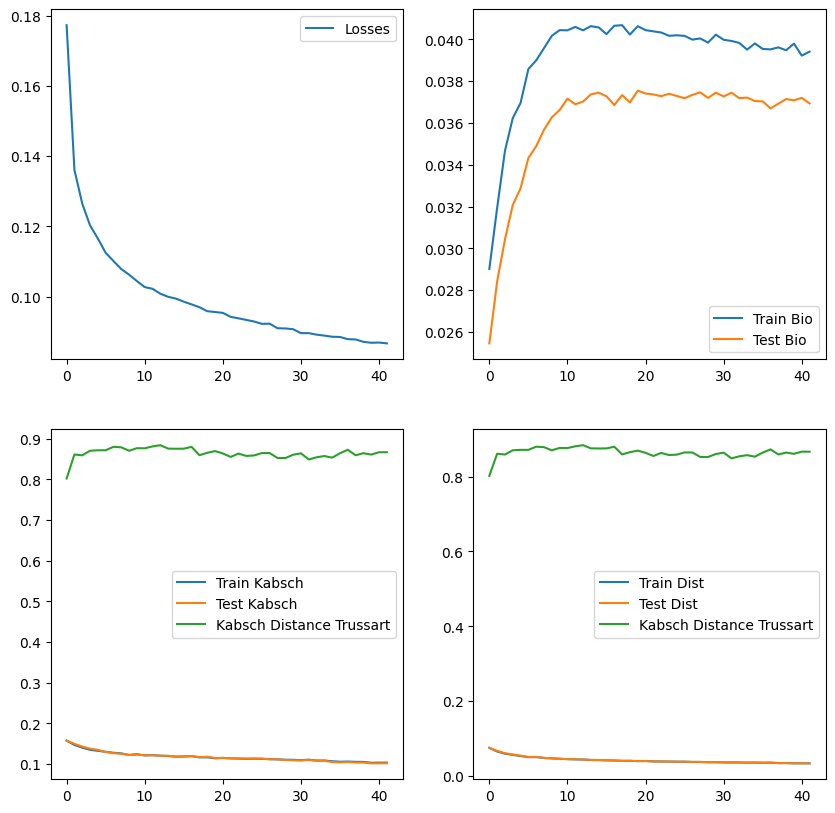

In [12]:
plot_losses(losses, train_biological_losses_all_epochs, test_biological_losses_all_epochs, train_kabsch_losses_all_epochs, test_kabsch_losses_all_epochs, fission_yeast_pearson_loss_all_epochs, train_distance_losses_all_epochs, test_distance_losses_all_epochs)


tensor(0.0002)
transformer_encoder.encoder_layers.self_attn.in_proj_weight
tensor(0.0001)
transformer_encoder.encoder_layers.self_attn.out_proj.weight
tensor(0.0001)
transformer_encoder.encoder_layers.linear1.weight
tensor(0.0001)
transformer_encoder.encoder_layers.linear2.weight
tensor(0.0007)
transformer_encoder.encoder_layers.norm1.weight
tensor(0.0007)
transformer_encoder.encoder_layers.norm2.weight
tensor(0.0002)
transformer_encoder.encoder_layers2.self_attn.in_proj_weight
tensor(7.9964e-05)
transformer_encoder.encoder_layers2.self_attn.out_proj.weight
tensor(8.8326e-05)
transformer_encoder.encoder_layers2.linear1.weight
tensor(6.1861e-05)
transformer_encoder.encoder_layers2.linear2.weight
tensor(0.0004)
transformer_encoder.encoder_layers2.norm1.weight
tensor(0.0005)
transformer_encoder.encoder_layers2.norm2.weight
tensor(2.5649e-05)
transformer_encoder.encoder.weight
tensor(0.0040)
transformer_encoder.decoder.weight
tensor(1.4012e-05)
linear_bin_layer.weight
tensor(1.2307e-05)
li

/Users/hva/Documents/3D-Chromatin/Chromatin3D/Data_Tools/Data_Plotting.py:107: UserWarning:

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



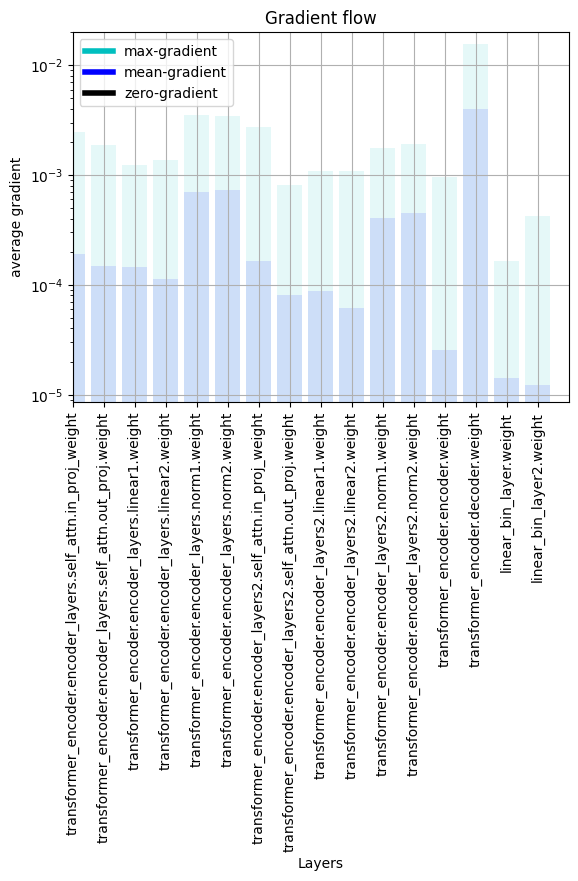

In [13]:
plot_grad_flow(model.named_parameters())

In [14]:
GRAPH_TESTED = 0

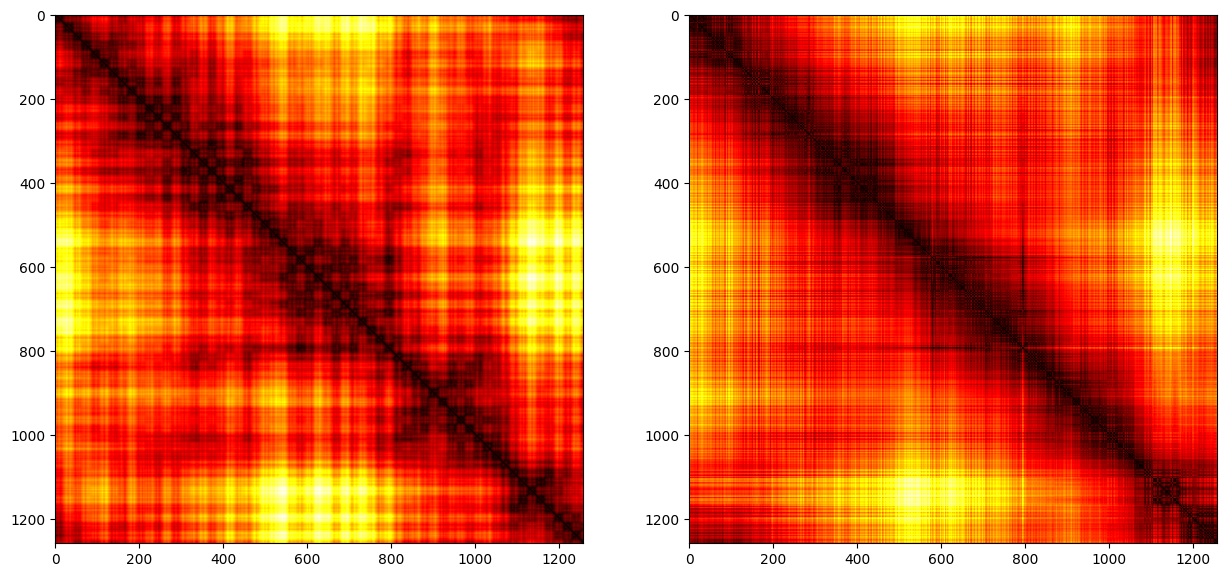

In [15]:
ground_truth_matrix = test_true_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
reconstruction_matrix = test_pred_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
plot_test_distance_matrix(ground_truth_matrix, reconstruction_matrix)

In [16]:
test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = np.asarray(range(len(x_pred)))
color1 = 'Viridis'
color2 = 'Viridis'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)))



Kabsch distance is 0.1231434243511654


<Figure size 50000x50000 with 0 Axes>

True vs Pred synthetic validation structures

In [17]:
test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]
pred_structure_unit_ball, true_structure_unit_ball = \
            kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)
d = np.negative(np.log(np.mean(np.divide(np.abs(pred_structure_unit_ball - true_structure_unit_ball),np.abs(true_structure_unit_ball)), axis=1)))

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = d
color1 = 'Viridis'
color2 = 'magma'
plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)))



Kabsch distance is 0.1231434243511654


<Figure size 50000x50000 with 0 Axes>

In [18]:
random_structure = np.random.random((1258,3))
test_true_structure = test_true_structures[GRAPH_TESTED]
print(lddt(torch.from_numpy(test_pred_structure_superposed).unsqueeze(0), torch.from_numpy(test_true_structure_superposed).unsqueeze(0)))

random_structure_superposed, true_to_random_structure_superposed = \
        kabsch_superimposition_numpy(random_structure, test_true_structure, EMBEDDING_SIZE)

print(lddt(torch.from_numpy(random_structure_superposed).unsqueeze(0), torch.from_numpy(true_to_random_structure_superposed).unsqueeze(0)))
#print(test_true_structures[GRAPH_TESTED].shape)


tensor([0.8318], dtype=torch.float64)
tensor([0.5969], dtype=torch.float64)


In [19]:
make_gif("", "gifs/fission_yeast_trans.gif")

Predicted Fission Yeast structure with each color being a chromosome

In [20]:


torch_fission_yeast_hic = torch.FloatTensor(fission_yeast_hic)
torch_fission_yeast_hic = torch.reshape(torch_fission_yeast_hic, (1, NB_BINS, NB_BINS))
torch_fission_yeast_hic = torch.repeat_interleave(torch_fission_yeast_hic, BATCH_SIZE, 0)

fission_yeast_pred_structure, fission_yeast_pred_distance, fission_yeast_pred_logits = model(torch_fission_yeast_hic)
fission_yeast_pred_structure = fission_yeast_pred_structure.detach().numpy()[0]

# Plot structures
x_pred = fission_yeast_pred_structure[:, 0]  
y_pred = fission_yeast_pred_structure[:, 1]
z_pred = fission_yeast_pred_structure[:, 2]

colorscale = np.full(len(fission_yeast_pred_structure[:,0]), 'some non specified color')
colorscale[:558] = 'red'
colorscale[558:1012] = 'green'
colorscale[1012:] = 'blue'
color = 'Viridis'
plot_pred_conf(fission_yeast_pred_structure, colorscale, color)


predicted confidences on the Fission yeast data and predicted structure plotted according to its confidence

In [21]:
confidence_metrics, pLLDTs = get_confidence_metrics(fission_yeast_pred_logits.detach().numpy()[0])
print(confidence_metrics)

77.53786764409631


In [22]:
color = 'magma'
plot_pred_conf(fission_yeast_pred_structure, pLLDTs, color)

Temerature Scaling for Calibration of predicted logits

In [23]:
orig_model = model
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_test_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)
scaled_model = ModelWithTemperature(orig_model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)
scaled_model.set_temperature(valid_loader)
m = torch.nn.LogSoftmax(dim=1)
nll_criterion = torch.nn.BCEWithLogitsLoss()
print(nll_criterion(m(logits_test_temp), labels_test_temp).item())
logits_test_temps_scaled = scaled_model.temperature_scale(logits_test_temp)

print(nll_criterion(m(logits_test_temps_scaled), labels_test_temp).item())

Before temperature - NLL: 0.041
tensor(0.8358, grad_fn=<MulBackward0>)
tensor(0.8356, grad_fn=<MulBackward0>)
tensor(0.8353, grad_fn=<MulBackward0>)
tensor(0.8351, grad_fn=<MulBackward0>)
tensor(0.8348, grad_fn=<MulBackward0>)
tensor(0.8345, grad_fn=<MulBackward0>)
tensor(0.8343, grad_fn=<MulBackward0>)
tensor(0.8341, grad_fn=<MulBackward0>)
tensor(0.8338, grad_fn=<MulBackward0>)
tensor(0.8336, grad_fn=<MulBackward0>)
tensor(0.8333, grad_fn=<MulBackward0>)
tensor(0.8331, grad_fn=<MulBackward0>)
tensor(0.8329, grad_fn=<MulBackward0>)
tensor(0.8327, grad_fn=<MulBackward0>)
tensor(0.8324, grad_fn=<MulBackward0>)
tensor(0.8322, grad_fn=<MulBackward0>)
tensor(0.8320, grad_fn=<MulBackward0>)
tensor(0.8318, grad_fn=<MulBackward0>)
tensor(0.8316, grad_fn=<MulBackward0>)
tensor(0.8314, grad_fn=<MulBackward0>)
tensor(0.8312, grad_fn=<MulBackward0>)
tensor(0.8311, grad_fn=<MulBackward0>)
tensor(0.8309, grad_fn=<MulBackward0>)
tensor(0.8307, grad_fn=<MulBackward0>)
tensor(0.8305, grad_fn=<MulBackw

In [24]:
confidence_metric_scaled, plddt_scaled = scale_logits(fission_yeast_pred_logits, scaled_model, BATCH_SIZE, NB_BINS)
print(confidence_metric_scaled)
print(plddt_scaled)

77.41274206233771
[73.28983836 73.91287742 73.12343005 ... 73.04064251 73.04875986
 73.11285137]


In [25]:
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_train_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)

Isotonic Regression for the calibration of logits with predicted calibrated confidence

In [26]:
confidence_metric_iso, pLDDT_iso = isotonic_calibration(logits_test_temp, labels_test_temp, fission_yeast_pred_logits)
print(confidence_metric_iso)
print(pLDDT_iso)

3.1705189511940643
3.1552267068794015
78.43456009923929
[73.12710528 74.4392027  73.07138236 ... 73.75541676 73.76916217
 73.82654514]


In [27]:
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_train_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)

Beta Calibration for the calibration of logits with predicted calibrated confidence

In [28]:
confidence_metric_beta, pLDDT_beta = beta_calibration(logits_test_temp, labels_test_temp, fission_yeast_pred_logits)
print(confidence_metric_beta)
print(pLDDT_beta)

3.1705189511940643
3.1469467233861845
78.2780350082865
[74.5259965  75.1223809  74.32710211 ... 74.59276298 74.65410414
 74.73919156]


Fission Yeast predicted structure according to the temperature scaled confidences

In [29]:
color = 'magma'
plot_pred_conf(fission_yeast_pred_structure, plddt_scaled, color)

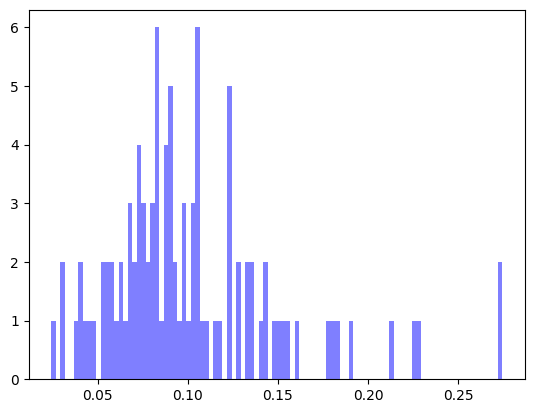

mean: 0.10212359229985511
median: 0.09000324988865256
variance: 0.002291590031547743


In [30]:
plot_hist_kabsch_distances(test_size, test_true_structures, test_pred_structures, EMBEDDING_SIZE)

In [31]:
RESULTS_ROOT = '../../saved_results/synthetic_random_fission_yeast/trans/'
LAMBDA_CONFIGURATION = str(LAMBDA_KABSCH)

In [32]:
np.savetxt(RESULTS_ROOT + 'synthetic_random_fission_yeast_trans_losses_10k_' + LAMBDA_CONFIGURATION + '.txt', losses)

np.savetxt(RESULTS_ROOT + 'synthetic_random_fission_yeast_trans_train_kabsch_losses_all_epochs_10k_' + 
           LAMBDA_CONFIGURATION + '.txt', train_kabsch_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_random_fission_yeast_trans_test_kabsch_losses_all_epochs_10k_' + 
           LAMBDA_CONFIGURATION + '.txt', test_kabsch_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_random_fission_yeast_trans_train_distance_losses_all_epochs_10k_' +
           LAMBDA_CONFIGURATION + '.txt', train_distance_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_random_fission_yeast_trans_test_distance_losses_all_epochs_10k_' + 
           LAMBDA_CONFIGURATION + '.txt', test_distance_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_random_fission_yeast_trans_fission_yeast_test_structure_10k_' +
               LAMBDA_CONFIGURATION + '.txt', fission_yeast_pred_structure)

In [33]:
CONFORMATION = str(0)
#2   5

In [34]:
np.savetxt(RESULTS_ROOT + '/structures/non_ae_synthetic_random_linear_trussart_test_structure_150_' +
               CONFORMATION + '.txt', fission_yeast_pred_structure)

In [35]:
np.savetxt(RESULTS_ROOT + 'synthetic_random_fission_yeast_trans_pearson_losses_all_epochs_10k_' + 
           CONFORMATION + '.txt', fission_yeast_pearson_loss_all_epochs)

In [36]:
torch.save(model, 
    '../../saved_models/synthetic_random_fission_yeast/trans/synthetic_random_fission_yeast_linear_model_10k_' 
           + LAMBDA_CONFIGURATION + '.pt')